# Taxi Tip Prediction Using Scikit-learn and Snap ML

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import mean_squared_error
import time
import warnings
import gc, sys
warnings.filterwarnings('ignore')

## Read and Analyze Data

In [2]:
raw_data = pd.read_csv("yellow_tripdata_2019-06.csv")
print("There are " + str(len(raw_data)) + " Observations in the dataset")
print("There are " +str(len(raw_data.columns)) + " variables in the dataset")

raw_data.head()

There are 3936004 Observations in the dataset
There are 18 variables in the dataset


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.0,1.0,N,145.0,145.0,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1.0,0.0,1.0,N,262.0,263.0,2.0,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1.0,4.4,1.0,N,74.0,7.0,2.0,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0.0,0.8,1.0,N,145.0,145.0,2.0,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.7,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


Each row in the dataset represents a taxi trip. As shown above, each row has 18 variables. One variable is called tip_amount and represents the target variable. Your objective will be to train a model that uses the other variables to predict the value of the tip_amount variable. Let's first clean the dataset and retrieve basic statistics about the target variable.

There are 2712719 Observations in the dataset
There are 17 Variables in the dataset


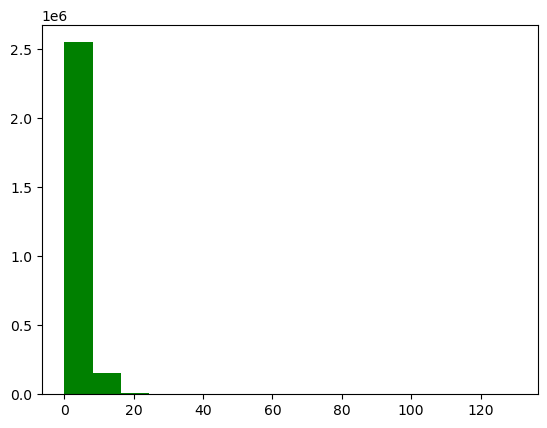

Minimum amount value is  0.01
Maximum amount value is  130.0
90% of the tips have a tip amount less or equal to  5.95


In [3]:
# some tips reported as 0 tips, it is assumed that these tips are payed in cash
# for this study we drop all those rows

raw_data = raw_data[raw_data['tip_amount'] > 0]

# we remove some outliers namely those where the tip was higher then fair cost
raw_data = raw_data[(raw_data['tip_amount'] <= raw_data['fare_amount'])]

# we remove trips with very large fare cost
raw_data = raw_data[((raw_data['fare_amount'] >= 2) & (raw_data['fare_amount'] < 200))]

# we remove the variables that contain target variables in it namely total amount
clean_data = raw_data.drop(['total_amount'], axis=1)

# release memory occupied by raw_data as we do not need it anymore
# we are dealing with a large dataset, thus we need to make sure we do not run out of memory
del raw_data
gc.collect()

# print the number of trips left in the dataset
print("There are " +str(len(clean_data)) + " Observations in the dataset")
print("There are " +str(len(clean_data.columns)) + " Variables in the dataset")

plt.hist(clean_data.tip_amount.values, 16, histtype='bar', facecolor = 'g')
plt.show()

print("Minimum amount value is " ,np.min(clean_data.tip_amount.values))
print("Maximum amount value is " ,np.max(clean_data.tip_amount.values))
print("90% of the tips have a tip amount less or equal to ", np.percentile(clean_data.tip_amount.values, 90))

In [4]:
clean_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.70,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,2.5
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2.0,1.60,1.0,N,79.0,125.0,1.0,9.5,3.0,0.5,1.00,0.0,0.3,2.5
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2.0,1.20,1.0,N,79.0,249.0,1.0,7.5,3.0,0.5,1.00,0.0,0.3,2.5
9,1,2019-06-01 00:29:12,2019-06-01 01:03:13,1.0,8.60,1.0,N,186.0,243.0,1.0,31.5,3.0,0.5,7.05,0.0,0.3,2.5
10,2,2019-06-01 00:01:48,2019-06-01 00:16:06,1.0,1.74,1.0,N,107.0,148.0,1.0,11.0,0.5,0.5,2.96,0.0,0.3,2.5


By looking at the dataset in more detail, we see that it contains information such as pick-up and drop-off dates/times, pick-up and drop-off locations, payment types, driver-reported passenger counts etc. Before actually training a ML model, we will need to preprocess the data. We need to transform the data in a format that will be correctly handled by the models. For instance, we need to encode the categorical features.

## Data Preprocessing

In this subsection you will prepare the data for training.

In [5]:
# Convert 'tpep pickup datetime' and 'tpep dropoff datetime' column to datetime object
clean_data['tpep_pickup_datetime'] = pd.to_datetime(clean_data['tpep_dropoff_datetime'])
clean_data['tpep_dropoff_datetime'] = pd.to_datetime(clean_data['tpep_dropoff_datetime'])

# Extract pickup and dropoff time
clean_data['pickup_hour'] = clean_data['tpep_pickup_datetime'].dt.hour
clean_data['dropoff_hour'] = clean_data['tpep_dropoff_datetime'].dt.hour

# Extract pickup and dropoff day of the week (0 = Monday, 6 = Sunday)
clean_data['pickup_day'] = clean_data['tpep_pickup_datetime'].dt.weekday
clean_data['dropoff_day'] = clean_data['tpep_dropoff_datetime'].dt.weekday

# Calculate the trip time in seconds
clean_data['trip_time'] = (clean_data['tpep_dropoff_datetime'] - clean_data['tpep_pickup_datetime']).dt.total_seconds()

# Ideally use the full dataset for this exercise.
# However, if you run into out-of-memory issues due to the data size, reduce it.
# For instance, in this example, we use only the first 200,000 samples.

first_n_rows = 200000
clean_data = clean_data.head(first_n_rows)

In [6]:
# drop the pickup and dropoff datetime
clean_data = clean_data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

# some features are categorical, we need to encode them
# to encode them we use one-hot encoding from the Pandas package
get_dummy_col = ["VendorID", "RatecodeID", "store_and_fwd_flag", "PULocationID", "DOLocationID", "payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
proc_data = pd.get_dummies(clean_data, columns= get_dummy_col)

# release memory occupied by clean_data as we do not need it anymore
# we are dealing with a large dataset, thus we need to make sure we do not run out of memory

del clean_data
gc.collect()

4180

In [7]:
# Extract the labels from the dataframe
y = proc_data[['tip_amount']].values.astype('float32')

# drop the target variable from the feature matrix
proc_data = proc_data.drop(['tip_amount'], axis=1)

# get the feature matrix used for training 
x = proc_data.values

# normalize the feature matrix
x = normalize(x, axis=1, norm ='l1', copy=False)

# print the shape of feature matrix and the labels
print('x_shape=', x.shape, 'y_shape=', y.shape)

x_shape= (200000, 516) y_shape= (200000, 1)


## Dataset Train/Test Split

Now that the dataset is ready for building the classification models, you need to first divide the pre-processed dataset into a subset to be used for training the model (the train set) and a subset to be used for evaluating the quality of the model (the test set).

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print("X training size= ", x_train.shape, "Y training size= ", y_train.shape)
print("X test size= ", x_test.shape, "Y test size= ", y_test.shape)

X training size=  (140000, 516) Y training size=  (140000, 1)
X test size=  (60000, 516) Y test size=  (60000, 1)


## Build a Decision Tree Regressor model with Scikit-Learn

In [9]:
from sklearn.tree import DecisionTreeRegressor

sklearn_dt = DecisionTreeRegressor(max_depth=8, random_state=35)

# train a Decision Tree Regressor using scikit-learn
t0 = time.time()
sklearn_dt.fit(x_train, y_train)
sklearn_time = time.time() - t0
print("Sklearn training time (s) : {0: .5f}".format(sklearn_time))

Sklearn training time (s) :  33.92726


## Build a Decision Tree Regressor model with Snap ML

In [10]:
from snapml import DecisionTreeRegressor

snapml_dt = DecisionTreeRegressor(max_depth=8, random_state=45, n_jobs=4)

# train a Decision Tree Regressor model using Snap ML
t0 = time.time()
snapml_dt.fit(x_train, y_train)
snapml_time = time.time() - t0
print("Snap Ml training time (s) : {0: .5f}".format(snapml_time))

Snap Ml training time (s) :  9.37732


## Evaluate the Scikit-Learn and Snap ML Decision Tree Regressor Models

In [11]:
training_speedup = sklearn_time/snapml_time
print("Decision tree snapMl vs Sklearn speedup  : {0: .2f}x". format(training_speedup))

Decision tree snapMl vs Sklearn speedup  :  3.62x


In [12]:
# run inference using the sklearn model
sklearn_pred = sklearn_dt.predict(x_test)

# evaluate mean squared error on the test dataset
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print("Sklearn MSE score : {0: .3f}".format(sklearn_mse))


Sklearn MSE score :  1.632


In [13]:
snapml_pred = snapml_dt.predict(x_test)

snapml_mse = mean_squared_error(y_test, snapml_pred)
print("SnapMl MSE score : {0: .3f}".format(snapml_mse))

SnapMl MSE score :  1.585


Lets train a `SnapML` `Decision Tree Regressor` with the `max_depth` parameter set to `12`, `random_state` set to `45`, and `n_jobs` set to `4` and compare its Mean Squared Error to the decision tree regressor we trained previously

In [15]:
tree = DecisionTreeRegressor(max_depth=12, random_state=45, n_jobs=4)

tree.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=12, n_jobs=4, random_state=45)

In [17]:
pred = tree.predict(x_test)

print("MSE: ", mean_squared_error(y_test, pred))

MSE:  1.66798527662593
